# Load dataset

In [1]:
import pandas as pd
import altair as alt
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
train_X = pd.read_csv('../Dataset/SMOTE_train_X.csv')
train_y = pd.read_csv('../Dataset/SMOTE_train_y.csv')
test_X = pd.read_csv('../Dataset/SMOTE_test_X.csv')
test_y = pd.read_csv('../Dataset/SMOTE_test_y.csv')

In [3]:
train_X.shape, train_y.shape

((145704, 191), (145704, 1))

# Load base model
candidates:
- Decision tree
- Randomforest
- ~~Support vector machine: very slow to train on this dataset.~~

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [5]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, precision_recall_curve

# Baseline

Set baseline by random guessing.  
Precision, Recall => 0.5  
AUC => 0.5

## Decision Tree

In [6]:
train_X = train_X[[c for c in train_X.columns if c not in ['user_id']]]
test_X = test_X[[c for c in test_X.columns if c not in ['user_id']]]

In [7]:
decision_tree_base = DecisionTreeClassifier(random_state=42)
decision_tree_base.fit(train_X, train_y)
pred_y = decision_tree_base.predict(test_X)

In [8]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,34072,1762
True positive,1592,34340


In [9]:
def get_score(test_y, pred_y):
    precision = precision_score(test_y, pred_y)
    recall = recall_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    return round(precision,2), round(recall,2), round(f1,2)

In [10]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base decision tree: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base decision tree: precision=0.95, recall=0.96, f1=0.95


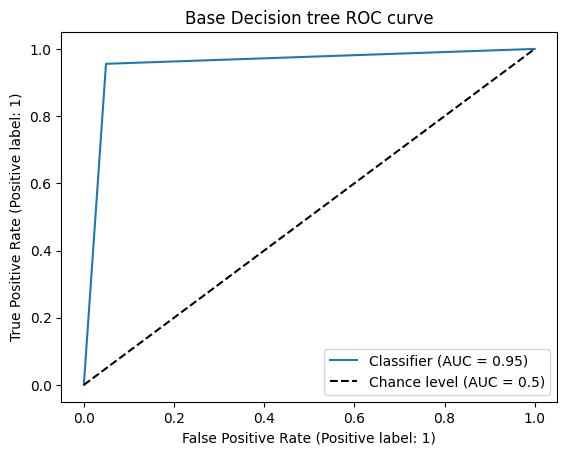

In [11]:
fig, ax = plt.subplots()
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True, ax=ax)
ax.set_title('Base Decision tree ROC curve');

## RandomForest

In [12]:
random_forest_base = RandomForestClassifier(random_state=42)
random_forest_base.fit(train_X, train_y)
pred_y = random_forest_base.predict(test_X)

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [13]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,35586,248
True positive,1703,34229


In [14]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base random forest: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base random forest: precision=0.99, recall=0.95, f1=0.97


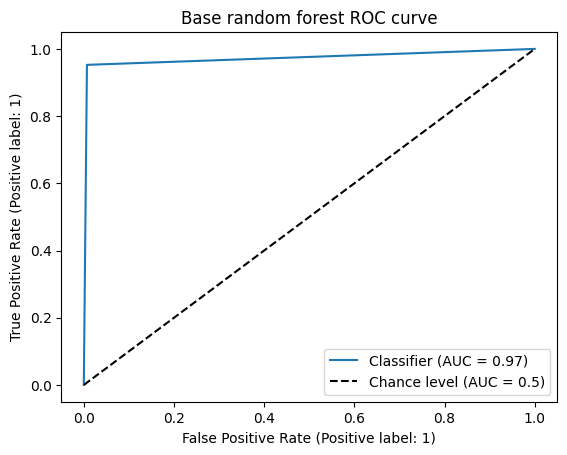

In [15]:
fig, ax = plt.subplots()
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True, ax=ax)
ax.set_title('Base random forest ROC curve');

# Model selection
Although Deicision tree model shows a bit higher recall score, random forest model's overall performance is better. Therefore, I'll keep developing Randomforest model.  

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
train_X.shape

(145704, 191)

In [18]:
param_grid = {
    'n_estimators': [10, 50, 100, 150, 170],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
random_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 170]},
             verbose=2)

In [19]:
print(grid_search.best_params_)

{'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 170}


In [30]:
random_forest = RandomForestClassifier(random_state=42, max_depth=30, min_samples_split=5, n_estimators=170)
random_forest.fit(train_X, train_y)
pred_y = random_forest.predict(test_X)

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [31]:
pd.DataFrame(confusion_matrix(test_y, pred_y), index=['True negative', 'True positive'], columns=['Pred negative', 'Pred positive'])

,Pred negative,Pred positive
True negative,35807,27
True positive,1851,34081


In [32]:
dt_precision, dt_recall, dt_f1 = get_score(test_y, pred_y)
print(f"Base random forest: precision={dt_precision}, recall={dt_recall}, f1={dt_f1}")

Base random forest: precision=1.0, recall=0.95, f1=0.97


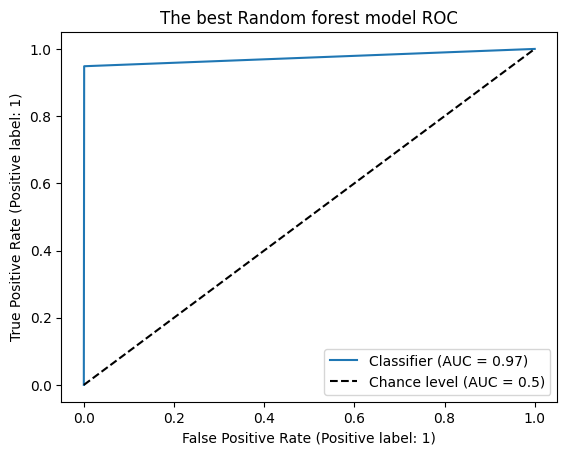

In [33]:
fig, ax = plt.subplots()
roc_display = RocCurveDisplay.from_predictions(test_y, pred_y, plot_chance_level=True, ax=ax)
ax.set_title('The best Random forest model ROC');

# Set threshold

As adjusting threshold, recall score increase to 0.97 from 0.95, precision gets lower to 0.90 form 1.0  
The model will catch 2 more fraud records while suspect innocent 10 more records.  
It would save \\$74 dollars (2 * \\$37) while losing \\$80 dollars (10 * $8) if obervations are 100 objects according to EDA conclusion.   
In actual dataset, non-fraud records are more, so the loss would be bigger.  
Therefore, it would be better to use the model without adjusting threshold.  

In [34]:
prob_y = random_forest.predict_proba(test_X)

In [35]:
precision, recall, thresholds = precision_recall_curve(test_y, prob_y[:,1])

In [36]:
for prec, rec, thres in zip(precision, recall, thresholds):
    if (rec >= 0.96) & (prec >= 0.90):
        print(f"on threshold({thres}) precision:{prec}, recall:{rec}")
        break

on threshold(0.11496589070709082) precision:0.9000103455410718, recall:0.9684403873984192


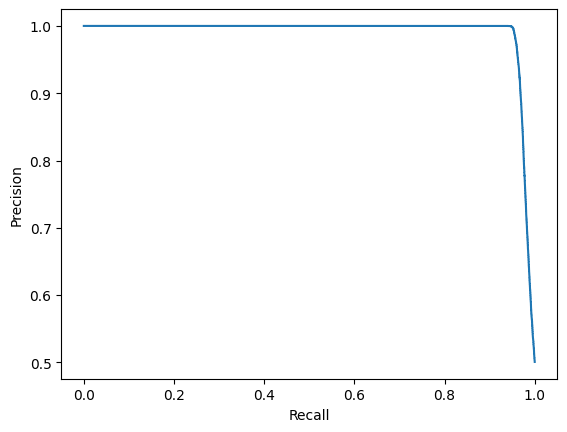

In [37]:
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Save the model

In [38]:
import pickle

In [39]:
with open('./trained_model/the_best_randomforest.pickle', 'wb') as file:
    pickle.dump(random_forest, file)

[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=170; total time=  14.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=170; total time=  14.7s
[CV] END max_depth=10, min_samples_split=10, n_estimators=150; total time=  12.9s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  16.8s
[CV] END max_depth=20, min_samples_split=2, n_estimators=170; total time=  29.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=170; total time=  29.2s
[CV] END max_depth=20, min_samples_split=10, n_estimators=170; total time=  28.0s
[CV] END max_depth=30, min_samples_split=2, n_estimators=150; total time=  30.7s
[CV] END max_depth=30, min_samples_split=5, n_estimators=150; total time=  30.6s
[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=  21.1s


/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   2.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=  13.3s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=150; total time=  12.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   8.7s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=10; total time=   1.8s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  16.9s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=10; total time=   1.9s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=50; total time=   8.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  17.0s
[CV] END max_depth=20, min_samples_split=10, n_estimators=10; total time=   2.0s
[CV] END max_depth=20, min_

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   2.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=  13.6s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   8.7s
[CV] END max_depth=10, min_samples_split=5, n_estimators=170; total time=  14.1s
[CV] END max_depth=10, min_samples_split=10, n_estimators=170; total time=  15.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=150; total time=  25.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=  17.2s
[CV] END max_depth=20, min_samples_split=10, n_estimators=10; total time=   2.0s
[CV] END max_depth=20, min_samples_split=10, n_estimators=50; total time=   8.6s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=  17.1s
[CV] END max_depth=20, min_samples_split=10, n_estimators=170; total time=  28.2s
[CV] END max_depth=30, min_samples_split=2, n_estimators=170; total time=  34.8s
[CV] END max_depth=30, mi

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=150; total time=  13.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=150; total time=  12.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   8.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=170; total time=  15.5s
[CV] END max_depth=20, min_samples_split=2, n_estimators=170; total time=  28.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=  25.3s
[CV] END max_depth=20, min_samples_split=10, n_estimators=150; total time=  25.0s
[CV] END .max_depth=30, min_samples_split=2, n_estimators=50; total time=  10.7s
[CV] END max_depth=30, min_samples_split=2, n_estimators=150; total time=  31.1s
[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=  20.5s
[CV] END max_depth=30, min_samples_split=10, n_estimators=10; total time=   2.3s
[CV] END max_depth=30, mi

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.9s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=10; total time=   1.4s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=10; total time=   1.0s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   8.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=10; total time=   1.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   4.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   4.4s
[CV] END max_depth=10, min_samples_split=10, n_estimators=150; total time=  13.1s
[CV] END max_depth=20, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=10; total time=   2.0s
[CV] END .max_depth=20, min_samples_split=5, n_estimators=10; total time=   2.1s
[CV] END .max_depth=20, min

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END .max_depth=10, min_samples_split=2, n_estimators=10; total time=   2.0s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   9.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=10; total time=   1.1s
[CV] END .max_depth=10, min_samples_split=5, n_estimators=50; total time=   4.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   8.6s
[CV] END max_depth=10, min_samples_split=10, n_estimators=10; total time=   1.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=10; total time=   1.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   4.4s
[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   8.6s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=10; total time=   1.8s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=10; total time=   1.8s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END max_depth=20, min_

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   5.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=170; total time=  14.6s
[CV] END max_depth=10, min_samples_split=5, n_estimators=150; total time=  12.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=150; total time=  13.2s
[CV] END .max_depth=20, min_samples_split=2, n_estimators=50; total time=   8.4s
[CV] END max_depth=20, min_samples_split=2, n_estimators=170; total time=  29.1s
[CV] END max_depth=20, min_samples_split=5, n_estimators=150; total time=  25.5s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=  17.2s
[CV] END .max_depth=30, min_samples_split=2, n_estimators=10; total time=   2.4s
[CV] END .max_depth=30, min_samples_split=2, n_estimators=50; total time=  10.5s
[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=  20.7s
[CV] END .max_depth=30, min_samples_split=5, n_estimators=10; total time=   2.5s
[CV] END .max_depth=30, mi

/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/haeinpark/miniconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expecte